## Foundations of Data Science | 4022 | Dr. Bahrak & Dr. Yaghoobzadeh
## CA6
***
### Amirreza Akbari | 810899045
### Reza Baghestani | 810899046
### Hananeh Jamali | 810899053
***
### 1402/03/03

## Install & Import Libraries

In [182]:
import importlib.util

required_libraries = ["numpy", "pandas", "matplotlib", "seaborn", "scikit-learn"]

for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        # Install the library
        !pip install {lib}
        
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math


## Task 1: Preprocessing

### 1. Initial Data Understanding

In [183]:
# Load datasets
diabetes_data = pd.read_csv('dataset_diabetes/diabetic_data.csv')
ids_mapping = pd.read_csv('dataset_diabetes/IDs_mapping.csv')

print("\n------------------------------------------------------     Info     ------------------------------------------------------\n")
# Summary information of the dataframe
print(diabetes_data.info())
print("\n------------------------------------------------------     Head     ------------------------------------------------------\n")
# First 5 rows of the dataframe
print(diabetes_data.head())
print("\n------------------------------------------------------     Tail     ------------------------------------------------------\n")
# Last 5 rows of the dataframe
print(diabetes_data.tail())



------------------------------------------------------     Info     ------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  o

### 2. Dropping Duplicates

In [184]:
# Calculate the number of duplicates in the dataframe
duplicates = diabetes_data.duplicated().sum()
# Display the number of duplicates in the dataframe
print(f"Number of duplicate rows: {duplicates}")
# Remove the duplicates from the dataframe
diabetes_data = diabetes_data.drop_duplicates()


Number of duplicate rows: 0


### 3. Remove Features with High Missing Value Ratio

In [185]:
# Calculate the number of missing values "?"
missing_count = (diabetes_data == '?').sum()

# Calculate the ratio of missing values to total values
missing_ratio = missing_count / diabetes_data.shape[0]

# Display the number of missing values and their ratio in each column
missing_values = pd.concat([missing_count, missing_ratio], axis=1, keys=['Number of missing values', 'Ratio to total values'])
missing_values = missing_values[missing_values['Number of missing values'] > 0]

# Sort the missing values DataFrame by the ratio of missing values in descending order
missing_values_sorted = missing_values.sort_values(by='Ratio to total values', ascending=False)
print(missing_values_sorted)

# Remove columns with high missing value ratio
missing_threshold = 0.3
high_missing_cols = missing_ratio[missing_ratio > missing_threshold].index

diabetes_data.drop(columns=high_missing_cols, inplace=True)

print(f"\nNumber of features with high missing value ratio: {len(high_missing_cols)}")
print(f"Removed features due to high missing value ratio: {list(high_missing_cols)}")


                   Number of missing values  Ratio to total values
weight                                98569               0.968585
medical_specialty                     49949               0.490822
payer_code                            40256               0.395574
race                                   2273               0.022336
diag_3                                 1423               0.013983
diag_2                                  358               0.003518
diag_1                                   21               0.000206

Number of features with high missing value ratio: 3
Removed features due to high missing value ratio: ['weight', 'payer_code', 'medical_specialty']


### 4. Replcaing Missing Values "?" with Null Values "NA"

In [186]:
# Calculate the number of "?" values in each column before replacement
question_mark_count = (diabetes_data == '?').sum()
question_mark_count = question_mark_count[question_mark_count > 0]

# Display the count of "?" values in each column before replacement
print("Number of '?' values in each column before replacement:")
print(question_mark_count)

# Replace "?" values with NaN
diabetes_data.replace("?", np.nan, inplace=True)

# Calculate the number of "?" values in each column after replacement
question_mark_count = (diabetes_data == '?').sum()
question_mark_count = question_mark_count[question_mark_count > 0]

# Display the count of "?" values in each column after replacement
print("\nNumber of '?' values in each column after replacement:")
print(question_mark_count)


Number of '?' values in each column before replacement:
race      2273
diag_1      21
diag_2     358
diag_3    1423
dtype: int64

Number of '?' values in each column after replacement:
Series([], dtype: int64)


### 5. Remove Features with Near Zero-Variance

Although some may argue that zero-variance variables may in fact have some influence, in the diabetes dataset a few factor variables with multiple levels are nzv. If to keep them, it would later generate considerable number of dummy variables and increase the computation complexities and resource requirements. Consequently, removed all nzv variables.

In [187]:
# Calculate variance for numerical columns
numeric_variance = diabetes_data.select_dtypes(include=[np.number]).var()

# Calculate variance for non-numeric columns
non_numeric_variance = diabetes_data.select_dtypes(exclude=[np.number]).apply(lambda col: pd.factorize(col)[0]).var()

# Combine variances from both numerical and non-numeric columns
combined_variance = pd.concat([numeric_variance, non_numeric_variance])

print(combined_variance)

# Find columns with low variance
low_variance_cols = combined_variance[combined_variance < 0.08].index

# Drop columns with low variance
diabetes_data = diabetes_data.drop(columns=low_variance_cols)

print(f"\nNumber of features with low variance: {len(low_variance_cols)}")
print(f"Removed features due to low variance: {list(low_variance_cols)}")


encounter_id                1.053503e+16
patient_nbr                 1.497408e+15
admission_type_id           2.089189e+00
discharge_disposition_id    2.788015e+01
admission_source_id         1.651675e+01
time_in_hospital            8.910868e+00
num_lab_procedures          3.870805e+02
num_procedures              2.909777e+00
num_medications             6.605733e+01
number_outpatient           1.605961e+00
number_emergency            8.657786e-01
number_inpatient            1.594824e+00
number_diagnoses            3.738810e+00
race                        5.602357e-01
gender                      2.486509e-01
age                         2.541103e+00
diag_1                      1.017526e+04
diag_2                      1.021462e+04
diag_3                      1.178051e+04
max_glu_serum               2.343314e-01
A1Cresult                   6.819725e-01
metformin                   2.254601e-01
repaglinide                 5.858393e-02
nateglinide                 9.062982e-03
chlorpropamide  

### 6. Remove Multiple Encounters of a Patient

It is unclear if these encounters, i.e. visits, are independent. There is a risk that these multiple visits of a patient might be related, hence introduce bias since some encounters of a patient then become correlated. To eliminate this risk, we keep one and only one encounter which has the maximum time_in_hospital, assuming time_in_hospital is characteristic for readmission and would present sufficient variance in training data.

In [188]:
# Find the index of the row with the maximum value in 'time_in_hospital' for each patient
max_time_indices = diabetes_data.groupby('patient_nbr')['time_in_hospital'].idxmax()

# Filter the original DataFrame to keep only the rows with the indices found above
diabetes_data = diabetes_data.loc[max_time_indices]


### 7. Remove Feature: patient_nbr

In [189]:
# Drop the feature named 'encounter_id'
diabetes_data.drop(columns=['patient_nbr'], inplace=True)


### 8. Manipulating Categorical Features

#### Gender

Remove rows with "Unknown" gender
Remaining gender types are either "Male" or "Female"

In [190]:
# Define a function to map gender values to allowed values
def map_gender(gender):
    allowed_values = ['Male', 'Female']
    if gender in allowed_values:
        return gender

# Apply the function to the 'gender' column
diabetes_data['gender'] = diabetes_data['gender'].apply(map_gender)

# Drop rows where the 'gender' column has values other than the allowed values
diabetes_data.dropna(subset=['gender'], inplace=True)


#### Age

Consolidated from a 10-level factor to 3 and numeric as:

1:

+ [0-10)
+ [10-20)
+ [20-30)
+ [30-40)
+ [40-50)
+ [50-60)

1.5:

+ [60-70)
+ [70-80)

2:

+ [80-90)
+ [90-100)

Considering those older than 60 are twice more likely to be readmitted.

In [191]:
# Define a function to map age ranges to numeric values
def map_age_range(age_range):
    lower_bound = int(age_range.split('-')[0].strip('['))
    if lower_bound < 60:
        return 1
    elif lower_bound < 80:
        return 1.5
    else:
        return 2

# Apply the function to the 'age' column and create a new 'age_numeric' column
diabetes_data['age_numeric'] = diabetes_data['age'].apply(map_age_range)

# Drop the original 'age' column
diabetes_data.drop(columns=['age'], inplace=True)


#### Admission Type

Consolidated from a 8-level factor to 2 as:

k (known):

+ 1 (Emergency)
+ 2 (Urgent)
+ 3 (Elective)
+ 4 (Newborn)
+ 7 (Trauma Center)

u (unknown):

+ 5 (Not Available)
+ 6 (NULL)
+ 8 (Not Mapped)

In [192]:
# Define a function to map admission type to known or unknown
def map_admission_type(admission_type_id):
    known_types = [1, 2, 3, 4, 7]
    unknown_types = [5, 6, 8]
    if admission_type_id in known_types:
        return 'k'
    elif admission_type_id in unknown_types:
        return 'u'
    else:
        return 'u' # Default to unknown if not found

# Apply the function to the 'admission_type_id' column and create a new 'admission_type' column
diabetes_data['admission_type'] = diabetes_data['admission_type_id'].apply(map_admission_type)

# Drop the original 'admission_type_id' column
diabetes_data.drop(columns=['admission_type_id'], inplace=True)


#### Admission Source

Consolidated from a 25-level factor to 5 as:

b (birth):

+ 11 (Normal Delivery)
+ 12 (Premature Delivery)
+ 13 (Sick Baby)
+ 14 (Extramural Birth)
+ 23 (Born inside this hospital)
+ 24 (born outside this hospital)

o (other):

+ 7 (Emergency Room)
+ 8 (Court/Law Enforcement)
+ 19 (Readmission to Same Home Health Agency)

r (referral):

+ 1 (Physician Referral)
+ 2 (Clinic Referral)
+ 3 (HMO Referral)

t (transfer):

+ 4 (Transfer from a hospital)
+ 5 ( Transfer from a Skilled Nursing Facility (SNF))
+ 6 ( Transfer from another health care facility)
+ 10 ( Transfer from critial access hospital)
+ 18 ( Transfer From Another Home Health Agency)
+ 22 ( Transfer from hospital inpt/same fac reslt in a sep claim)
+ 25 ( Transfer from Ambulatory Surgery Center)
+ 26 (Transfer from Hospice)

u (unknown):

+ 9 (Not Available)
+ 15 (Not Available)
+ 17 (NULL)
+ 20 (Not Mapped)
+ 21 (Unknown/Invalid)

In [193]:
# Define a function to map admission source to birth, other, referral, transfer and unknown
def map_admission_source(admission_source_id):
    birth_types = [11, 12, 13, 14, 23, 24]
    other_types = [7, 8, 19]
    referral_types = [1, 2, 3]
    transfer_types = [4, 5, 6, 10, 18, 22, 25, 26]
    unknown_types = [9, 15, 17, 20, 21]
    
    if admission_source_id in birth_types:
        return 'b'
    elif admission_source_id in other_types:
        return 'o'
    elif admission_source_id in referral_types:
        return 'r'
    elif admission_source_id in transfer_types:
        return 't'
    elif admission_source_id in unknown_types:
        return 'u'
    else:
        return 'u'  # Default to unknown if not found

# Apply the function to the 'admission_source_id' column and create a new 'admission_source' column
diabetes_data['admission_source'] = diabetes_data['admission_source_id'].apply(map_admission_source)

# Drop the original 'admission_source_id' column
diabetes_data.drop(columns=['admission_source_id'], inplace=True)


#### Discharge Disposition

Consolidated from a 30-level factor to 5 as:

d (discharge):

+ 1 (Discharged to home)
+ 2 (Discharged/transferred to another short term hospital)
+ 3 (Discharged/transferred to SNF)
+ 4 (Discharged/transferred to ICF)
+ 5 (Discharged/transferred to another type of inpatient care institution)
+ 6 (Discharged/transferred to home with home health service)
+ 8 (Discharged/transferred to home under care of Home IV provider)
+ 10 (Neonate discharged to another hospital for neonatal aftercare)
+ 15 (Discharged/transferred within this institution to Medicare approved swing bed)
+ 16 (Discharged/transferred/referred another institution for outpatient services)
+ 17 (Discharged/transferred/referred to this institution for outpatient services)
+ 22 (Discharged/transferred to another rehab fac including rehab units of a hospital .)
+ 23 (Discharged/transferred to a long term care hospital.)
+ 24 (Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.)
+ 27 (Discharged/transferred to a federal health care facility.)
+ 28 (Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital)
+ 29 (Discharged/transferred to a Critical Access Hospital (CAH).)
+ 30 (Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere)

e (expired):

+ 11 (Expired)
+ 19 (Expired at home. Medicaid only, hospice.)
+ 20 (Expired in a medical facility. Medicaid only, hospice.)
+ 21 (Expired, place unknown. Medicaid only, hospice.)

h (hospice):

+ 13 (Hospice / home)
+ 14 (Hospice / medical facility)

o (other):

+ 7 (Left AMA)
+ 9 (Admitted as an inpatient to this hospital)
+ 12 (Still patient or expected to return for outpatient services)

u (unknown):

+ 18 (NULL)
+ 25 (Not Mapped)
+ 26 (Unknown/Invalid)

In [194]:
# Define a function to map discharge disposition to discharge, expired, hospice, other and unknown
def map_discharge_disposition(discharge_disposition_id):
    discharge_types = [1, 2, 3, 4, 5, 6, 8, 10, 15, 16, 17, 22, 23, 24, 27, 28, 29, 30]
    expired_types = [11, 19, 20, 21]
    hospice_types = [13, 14]
    other_types = [7, 9, 12]
    unknown_types = [18, 25, 26]

    if discharge_disposition_id in discharge_types:
        return 'd'
    elif discharge_disposition_id in expired_types:
        return 'e'
    elif discharge_disposition_id in hospice_types:
        return 'h'
    elif discharge_disposition_id in other_types:
        return 'o'
    elif discharge_disposition_id in unknown_types:
        return 'u'
    else:
        return 'u'  # Default to unknown if not found

# Apply the function to the 'discharge_disposition_id' column and create a new 'discharge_disposition' column
diabetes_data['discharge_disposition'] = diabetes_data['discharge_disposition_id'].apply(map_discharge_disposition)

# Drop the original 'discharge_disposition_id' column
diabetes_data.drop(columns=['discharge_disposition_id'], inplace=True)


#### Diagnostic Information

Consolidated variables diag_1, diag_2 and diag_3 from a more than 700-level factor to 9 as:

c (circulatory): diseases of the circulatory system

+ 390-459
+ 785

db (diabetes): diabetes mellitus

+ 250.xx

dg (digestive): diseases of the digestive system

+ 520-579
+ 787

g (genitourinary): diseases of the genitourinary system

+ 580-629
+ 788

i (injury): injury and poisoning

+ 800-999

m (musculoskeletal): diseases of the musculoskeletal system and connective tissue

+ 710-739

n (neoplasms): neoplasms

+ 140-239

o (other):

+ 780, 781, 784, 790-799        other symptoms, signs, and ill-defined conditions
+ 240-279 without 250           endocrine, nutritional, and metabolic diseases and immunity disorders, without diabetes
+ 680-709, 782                  diseases of the skin and subcutaneous tissue
+ 001-139                       infectious and parasitic diseases
+ 290-319                       mental disorders
+ E-V                           external causes of injury and supplemental classification
+ 280-289                       diseases of the blood and blood-forming organs
+ 320-359                       diseases of the nervous system
+ 630-679                       complications of pregnancy, childbirth, and the puerperium
+ 360-389                       diseases of the sense organs
+ 740-759                       congenital anomalies

r (respiratory): diseases of the respiratory system

+ 460-519
+ 786

In [195]:
# Define a function to map diagnosis codes to categories
def map_diagnosis_category(diagnosis_code):
    # Define the diagnosis code categories
    circulatory = list(range(390, 460)) + [785]
    diabetes = [250]
    digestive = list(range(520, 580)) + [787]
    genitourinary = list(range(580, 630)) + [788]
    injury = list(range(800, 1000))
    musculoskeletal = list(range(710, 740))
    neoplasms = list(range(140, 240))
    other = list(set([781] + [782] + [784] + list(range(790, 800)) + list(range(240, 280)) + list(range(680, 710)) + list(range(1, 140)) + list(range(290, 320)) + list(range(280, 290)) + list(range(320, 360)) + list(range(630, 680)) + list(range(360, 390)) + list(range(740, 760))) - {250})
    respiratory = list(range(460, 520)) + [786]
    
    # Convert the diagnosis code to string
    diagnosis_code = str(diagnosis_code)
    
    # Check for non-numeric codes starting with 'E' or 'V'
    if diagnosis_code.startswith('E') or diagnosis_code.startswith('V'):
        return 'o'  # Other category for codes starting with 'E' or 'V'
    
    try:
        diagnosis_code = int(diagnosis_code)
    except ValueError:
        return 'o'  # Other category for invalid numeric codes

    # Check the numeric diagnosis code against the categories
    if diagnosis_code in circulatory:
        return 'c'
    elif diagnosis_code in diabetes:
        return 'db'
    elif diagnosis_code in digestive:
        return 'dg'
    elif diagnosis_code in genitourinary:
        return 'g'
    elif diagnosis_code in injury:
        return 'i'
    elif diagnosis_code in musculoskeletal:
        return 'm'
    elif diagnosis_code in neoplasms:
        return 'n'
    elif diagnosis_code in other:
        return 'o'
    elif diagnosis_code in respiratory:
        return 'r'
    else:
        return 'o'  # Default to other if not found

# Apply the function to the 'diag_1' column and create a new 'diag_1_category' column
diabetes_data['diag_1_category'] = diabetes_data['diag_1'].apply(map_diagnosis_category)

# Apply the function to the 'diag_2' column and create a new 'diag_2_category' column
diabetes_data['diag_2_category'] = diabetes_data['diag_2'].apply(map_diagnosis_category)

# Apply the function to the 'diag_3' column and create a new 'diag_3_category' column
diabetes_data['diag_3_category'] = diabetes_data['diag_3'].apply(map_diagnosis_category)

# Drop the original 'diag_1', 'diag_2', and 'diag_3' columns
diabetes_data.drop(columns=['diag_1', 'diag_2', 'diag_3'], inplace=True)


### 9. Identifying Numerical & Categorical Features

Unique values in each column:

encounter_id             71515
race                         5
gender                       2
time_in_hospital            14
num_lab_procedures         118
num_procedures               7
num_medications             75
number_outpatient           33
number_emergency            25
number_inpatient            16
number_diagnoses            16
max_glu_serum                3
A1Cresult                    3
metformin                    4
glipizide                    4
glyburide                    4
pioglitazone                 4
insulin                      4
change                       2
diabetesMed                  2
readmitted                   3
age_numeric                  3
admission_type               2
admission_source             5
discharge_disposition        5
diag_1_category              9
diag_2_category              9
diag_3_category              9
dtype: int64


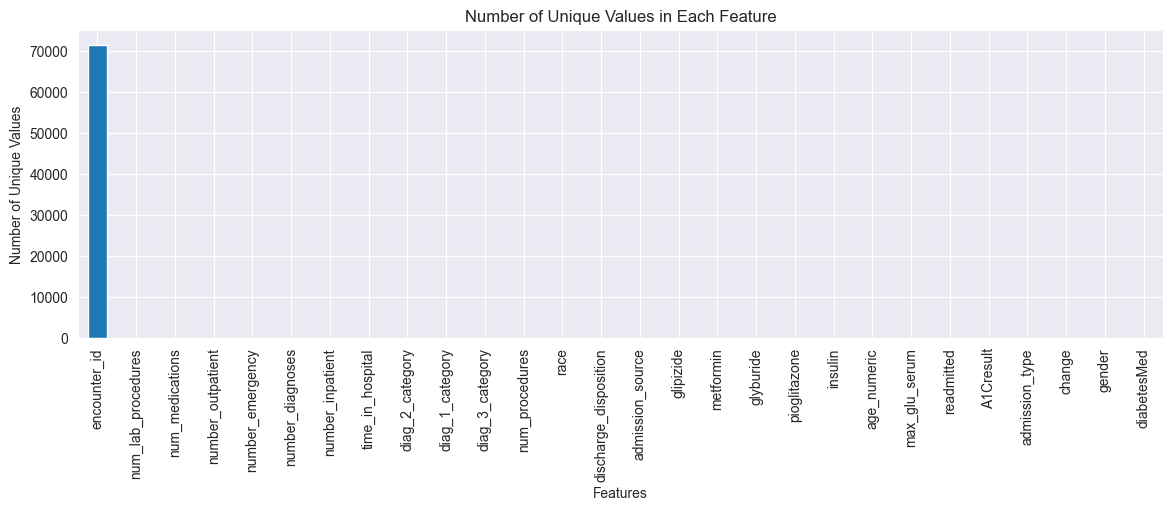

Number of Categorical Features: 18
Number of Numerical Features: 10
Number of Potential Categorical Features: 1

Categorical Features: ['race', 'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 'glipizide', 'glyburide', 'pioglitazone', 'insulin', 'change', 'diabetesMed', 'readmitted', 'admission_type', 'admission_source', 'discharge_disposition', 'diag_1_category', 'diag_2_category', 'diag_3_category']

Numerical Features: ['encounter_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_numeric']

Potential Categorical Features: ['age_numeric']


In [196]:
# Drop 'encounter_id' column
diabetes_data_without_id = diabetes_data.drop(columns=['encounter_id'])

# Calculate unique counts excluding 'encounter_id' column
unique_counts = diabetes_data_without_id.nunique()

# Display the unique counts
print(f"Unique values in each column:\n\n{unique_counts}")

# Sort the unique counts
unique_counts_sorted = unique_counts.sort_values(ascending=False)

# Plot the sorted unique counts
plt.figure(figsize=(14, 4))
unique_counts_sorted.plot(kind='bar')
plt.title('Number of Unique Values in Each Feature')
plt.xlabel('Features')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=90)
plt.show()

# Identify categorical features (object types)
categorical_features = diabetes_data.select_dtypes(include=['object']).columns.tolist()
# Identify numerical features (float or int types)
numerical_features = diabetes_data.select_dtypes(include=[np.number]).columns.tolist()

# Identify numerical categories that are potentially categorical features (based on low number of unique values)
potential_categorical_features = [col for col in diabetes_data.columns if diabetes_data[col].nunique() < 20]
# Finding id features (names end with "_id" and have less than 100 unique values)
id_features = [col for col in diabetes_data.columns if col.endswith('_id') and diabetes_data[col].nunique() < 100]
# Finding definitely numerical features (names start with "num_", "number_", or "time_")
definitely_numerical_features = [col for col in diabetes_data.columns if col.startswith(('num_', 'number_', 'time_'))]
# Updating the potential_categorical_features
potential_categorical_features = list(set(potential_categorical_features + id_features) - set(definitely_numerical_features) - set(categorical_features))

print(f"Number of Categorical Features: {len(categorical_features)}")
print(f"Number of Numerical Features: {len(numerical_features)}")
print(f"Number of Potential Categorical Features: {len(potential_categorical_features)}")

print("\nCategorical Features:", categorical_features)
print("\nNumerical Features:", numerical_features)
print("\nPotential Categorical Features:", potential_categorical_features)


### 10. Handle Missing Values

In [197]:
# Calculate the number of missing values before imputation
missing_count = diabetes_data.isnull().sum()
missing_count = missing_count[missing_count > 0]

# Display the count of missing values before imputation
print("Number of missing values before imputation:")
print(missing_count)

# Separate rows with and without missing 'race' values
data_with_race = diabetes_data[diabetes_data['race'].notna()]
data_missing_race = diabetes_data[diabetes_data['race'].isna()]

# Drop the 'race' column from the rows without missing values to prepare the training set
X = data_with_race.drop(columns=['race'])
y = data_with_race['race']

# Encode categorical variables and standardize numerical variables
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=[np.number]).columns

# Label encoding for categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    if col in data_missing_race.columns:
        data_missing_race[col] = data_missing_race[col].astype(str).map(lambda s: '<unknown>' if pd.isna(s) else s)
        data_missing_race[col] = le.transform(data_missing_race[col])
    label_encoders[col] = le

# Standardize numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
data_missing_race[numerical_cols] = scaler.transform(data_missing_race[numerical_cols])

# Split the data with race into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

# Initialize the models
models = {
    'Random Forest': RandomForestClassifier(random_state=28),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=28)
}

# Train the models, evaluate their performance, and find the best model
best_model = None
best_accuracy = 0
best_model_name = ""

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy:.4f}')
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = model_name

print(f'\nBest Model: {best_model_name} with Accuracy: {best_accuracy:.4f}')

# Impute missing 'race' values using the best performing model
best_model.fit(X, y)

# Predict missing 'race' values
X_missing = data_missing_race.drop(columns=['race'])
data_missing_race['race'] = best_model.predict(X_missing)

# Combine the imputed rows with the original dataset
imputed_data = pd.concat([data_with_race, data_missing_race])

# Replace the imputed 'race' column in the original dataframe
diabetes_data.loc[data_missing_race.index, 'race'] = data_missing_race['race']

# Calculate the number of missing values after imputation
missing_count = diabetes_data.isnull().sum()
missing_count = missing_count[missing_count > 0]

# Display the count of missing values after imputation
print("\nNumber of missing values after imputation:")
print(missing_count)


Number of missing values before imputation:
race              1918
max_glu_serum    68014
A1Cresult        58487
dtype: int64


C:\Users\Amirreza\AppData\Local\Temp\ipykernel_18244\1469273282.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_missing_race[col] = data_missing_race[col].astype(str).map(lambda s: '<unknown>' if pd.isna(s) else s)
C:\Users\Amirreza\AppData\Local\Temp\ipykernel_18244\1469273282.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_missing_race[col] = le.transform(data_missing_race[col])
C:\Users\Amirreza\AppData\Local\Temp\ipykernel_18244\1469273282.py:27: SettingWithCopyWarning: 
A value is t

Random Forest Accuracy: 0.7741
KNN Accuracy: 0.7353
Gradient Boosting Accuracy: 0.7721

Best Model: Random Forest with Accuracy: 0.7741

Number of missing values after imputation:
max_glu_serum    68014
A1Cresult        58487
dtype: int64


C:\Users\Amirreza\AppData\Local\Temp\ipykernel_18244\1469273282.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_missing_race['race'] = best_model.predict(X_missing)


The missing values of max_glu_serum and A1Cresult indicate that the related tests are not taken from the patient at all. This data shouldn't be filled.
The missing values of race of patients are sensitive data that can't be imputed using simple methods such as mean/median/mode imputation or forward/backward fill and can only be imputed using a proper machine learning model. 

### 11. Manipulating Categorical Features

In [198]:
# Define categorical features
categorical_features = diabetes_data.select_dtypes(include=['object']).columns.tolist()

# Types of features before label encoding
before_encoding_dtypes = diabetes_data.dtypes

# Label encoding for categorical features
label_encoders = {}
label_encoding_table = pd.DataFrame(columns=['Column', 'Original', 'Encoded'])

for col in categorical_features:
    le = LabelEncoder()
    diabetes_data[col] = le.fit_transform(diabetes_data[col].astype(str))
    label_encoders[col] = le

    # Create a temporary DataFrame for the current column's label encoding
    col_encoding = pd.DataFrame({'Original': le.classes_, 'Encoded': range(len(le.classes_))})
    col_encoding['Column'] = col
    label_encoding_table = pd.concat([label_encoding_table, col_encoding], ignore_index=True)

# Types of features after label encoding
after_encoding_dtypes = diabetes_data.dtypes

# Concatenate the data types before and after encoding
dtypes_comparison = pd.concat([before_encoding_dtypes, after_encoding_dtypes], axis=1, keys=['Before Encoding', 'After Encoding'])

# Print the concatenated data types comparison
print("\nData Types Comparison (Before and After Label Encoding):\n")
print(dtypes_comparison)

# Save the label encoding table to a CSV file
label_encoding_table.to_csv('label_encodings.csv', index=False)

# Ensure the entire DataFrame is printed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Print the label encoding table
print("\nLabel Encoding Table:\n")
print(label_encoding_table)

# Revert pandas display options to default
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')



Data Types Comparison (Before and After Label Encoding):

                      Before Encoding After Encoding
encounter_id                    int64          int64
race                           object          int32
gender                         object          int32
time_in_hospital                int64          int64
num_lab_procedures              int64          int64
num_procedures                  int64          int64
num_medications                 int64          int64
number_outpatient               int64          int64
number_emergency                int64          int64
number_inpatient                int64          int64
number_diagnoses                int64          int64
max_glu_serum                  object          int32
A1Cresult                      object          int32
metformin                      object          int32
glipizide                      object          int32
glyburide                      object          int32
pioglitazone                   object   

### 12. Remove Feature : encounter_id

In [199]:
# Save the encounter_id column for saving final results
result_df = diabetes_data[['encounter_id']].copy()

# Drop the feature named 'encounter_id'
diabetes_data.drop(columns=['encounter_id'], inplace=True)


### 13. Remove Outliers

In [200]:
# function to detect outliers
def detect_outliers(df):
    outliers = {}
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    return outliers

outliers = detect_outliers(diabetes_data)

# Filter and sort outliers with more than 0 outliers
filtered_outliers = {col: count for col, count in outliers.items() if count > 0}
sorted_outliers = dict(sorted(filtered_outliers.items(), key=lambda item: item[1], reverse=True))

# Print the results in descending order
print("Number of outliers in each column with more than 0 outliers:")
for col, count in sorted_outliers.items():
    print(f"{col}: {count}")

# for col in diabetes_data.columns:
#     Q1 = diabetes_data[col].quantile(0.25)
#     Q3 = diabetes_data[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     diabetes_data = diabetes_data[(diabetes_data[col] >= lower_bound) & (diabetes_data[col] <= upper_bound)]


Number of outliers in each column with more than 0 outliers:
diabetesMed: 16820
race: 16154
metformin: 14963
number_inpatient: 14594
A1Cresult: 13028
number_outpatient: 9908
glipizide: 9083
glyburide: 7777
admission_type: 7747
number_emergency: 5834
discharge_disposition: 5378
pioglitazone: 5312
admission_source: 5168
num_procedures: 4159
max_glu_serum: 3501
num_medications: 1810
number_diagnoses: 236
num_lab_procedures: 104


### 14. Remove Highly Correlated Features

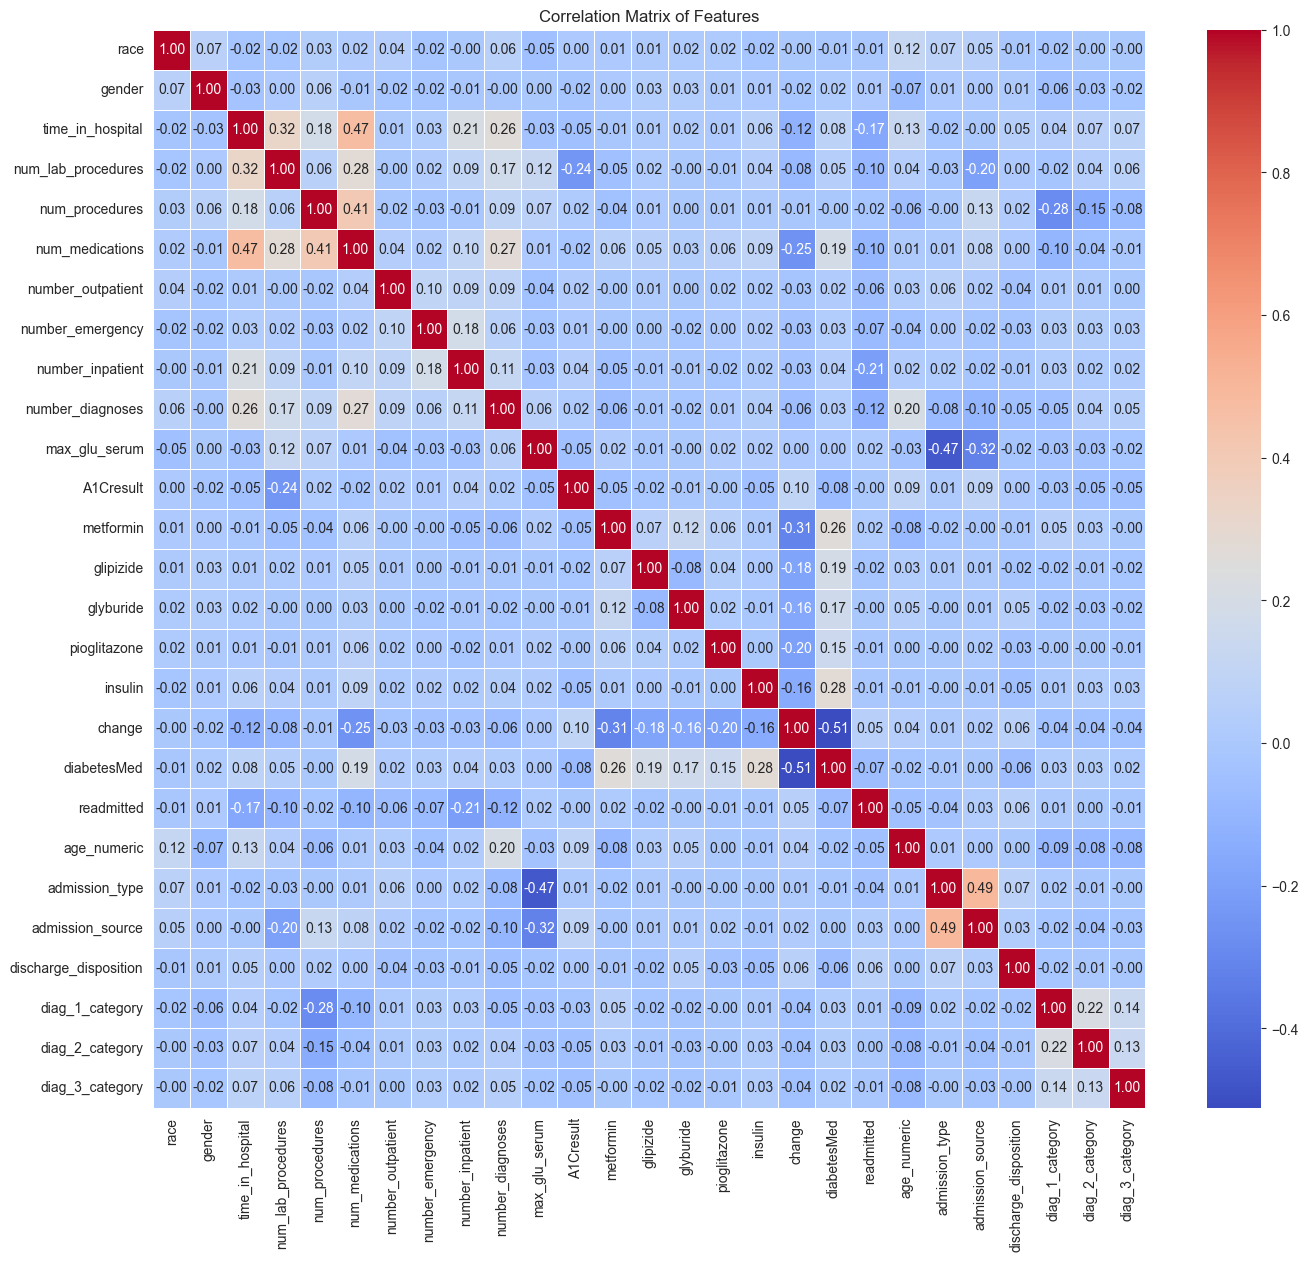


Number of features with high correlation: 0
Removed features due to high correlation: []


In [201]:
# Generate and plot the correlation matrix
correlation_matrix = diabetes_data.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

abs_corr_matrix = correlation_matrix.abs()
high_corr_var = np.where(abs_corr_matrix > 0.9)
high_corr_var = [(abs_corr_matrix.columns[x], abs_corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

# Store names of features that will be dropped
features_to_drop = []

for (col1, col2) in high_corr_var:
    if col1 in diabetes_data.columns:
        features_to_drop.append(col1)
        diabetes_data = diabetes_data.drop(columns=[col1])

# Print the names of features that will be dropped
print(f"\nNumber of features with high correlation: {len(features_to_drop)}")
print(f"Removed features due to high correlation: {list(features_to_drop)}")


### 15. Standardize Features

In [202]:
# Identify numerical features
numerical_features = diabetes_data.select_dtypes(include=[np.number]).columns.tolist()

# Separate numerical features from the dataframe
numerical_data = diabetes_data[numerical_features]

# Standardize the numerical features
scaler = StandardScaler()
standardized_data = scaler.fit_transform(numerical_data)
df_standardized = pd.DataFrame(standardized_data, columns=numerical_features)

# Calculate the mean, standard deviation, minimum, median and maximum of each feature after standardization
df_mean_standardized = df_standardized.mean(axis=0)
df_std_dev_standardized = df_standardized.std(axis=0)
df_min_values_standardized = df_standardized.min(axis=0)
df_median_values_standardized = np.median(df_standardized, axis=0)
df_max_values_standardized = df_standardized.max(axis=0)

# Create a DataFrame to display the statistics after standardization
df_standardized_stats = pd.DataFrame({
    'Mean': df_mean_standardized,
    'Std Dev': df_std_dev_standardized,
    'Minimum': df_min_values_standardized,
    'Median': df_median_values_standardized,
    'Maximum': df_max_values_standardized
})

# Display the DataFrame
print("Standardized Data:")
print(df_standardized_stats)


Standardized Data:
                               Mean   Std Dev   Minimum    Median    Maximum
race                  -6.994646e-17  1.000007 -1.985628  0.372546   2.730720
gender                 2.384538e-17  1.000007 -0.938502 -0.938502   1.065528
time_in_hospital       1.224063e-16  1.000007 -1.182129 -0.238764   2.905785
num_lab_procedures    -7.630523e-17  1.000007 -2.158463  0.043821   4.398337
num_procedures         3.258869e-17  1.000007 -0.837019 -0.274996   2.535119
num_medications       -3.775519e-17  1.000007 -1.785835 -0.161323   7.497086
number_outpatient      3.656292e-17  1.000007 -0.273256 -0.273256  35.828605
number_emergency      -1.987115e-18  1.000007 -0.194370 -0.194370  99.364951
number_inpatient       3.020415e-17  1.000007 -0.395570 -0.395570  22.914971
number_diagnoses      -1.303548e-16  1.000007 -3.212215  0.333918   4.386642
max_glu_serum         -5.881861e-17  1.000007 -6.732453  0.204075   0.204075
A1Cresult              4.212684e-17  1.000007 -3.293738  

### 16. Save Preprocessed Data

In [203]:
# Save preprocessed data for next steps
df_standardized.to_csv('diabetes_preprocessed.csv', index=False)


### 17. Visualization

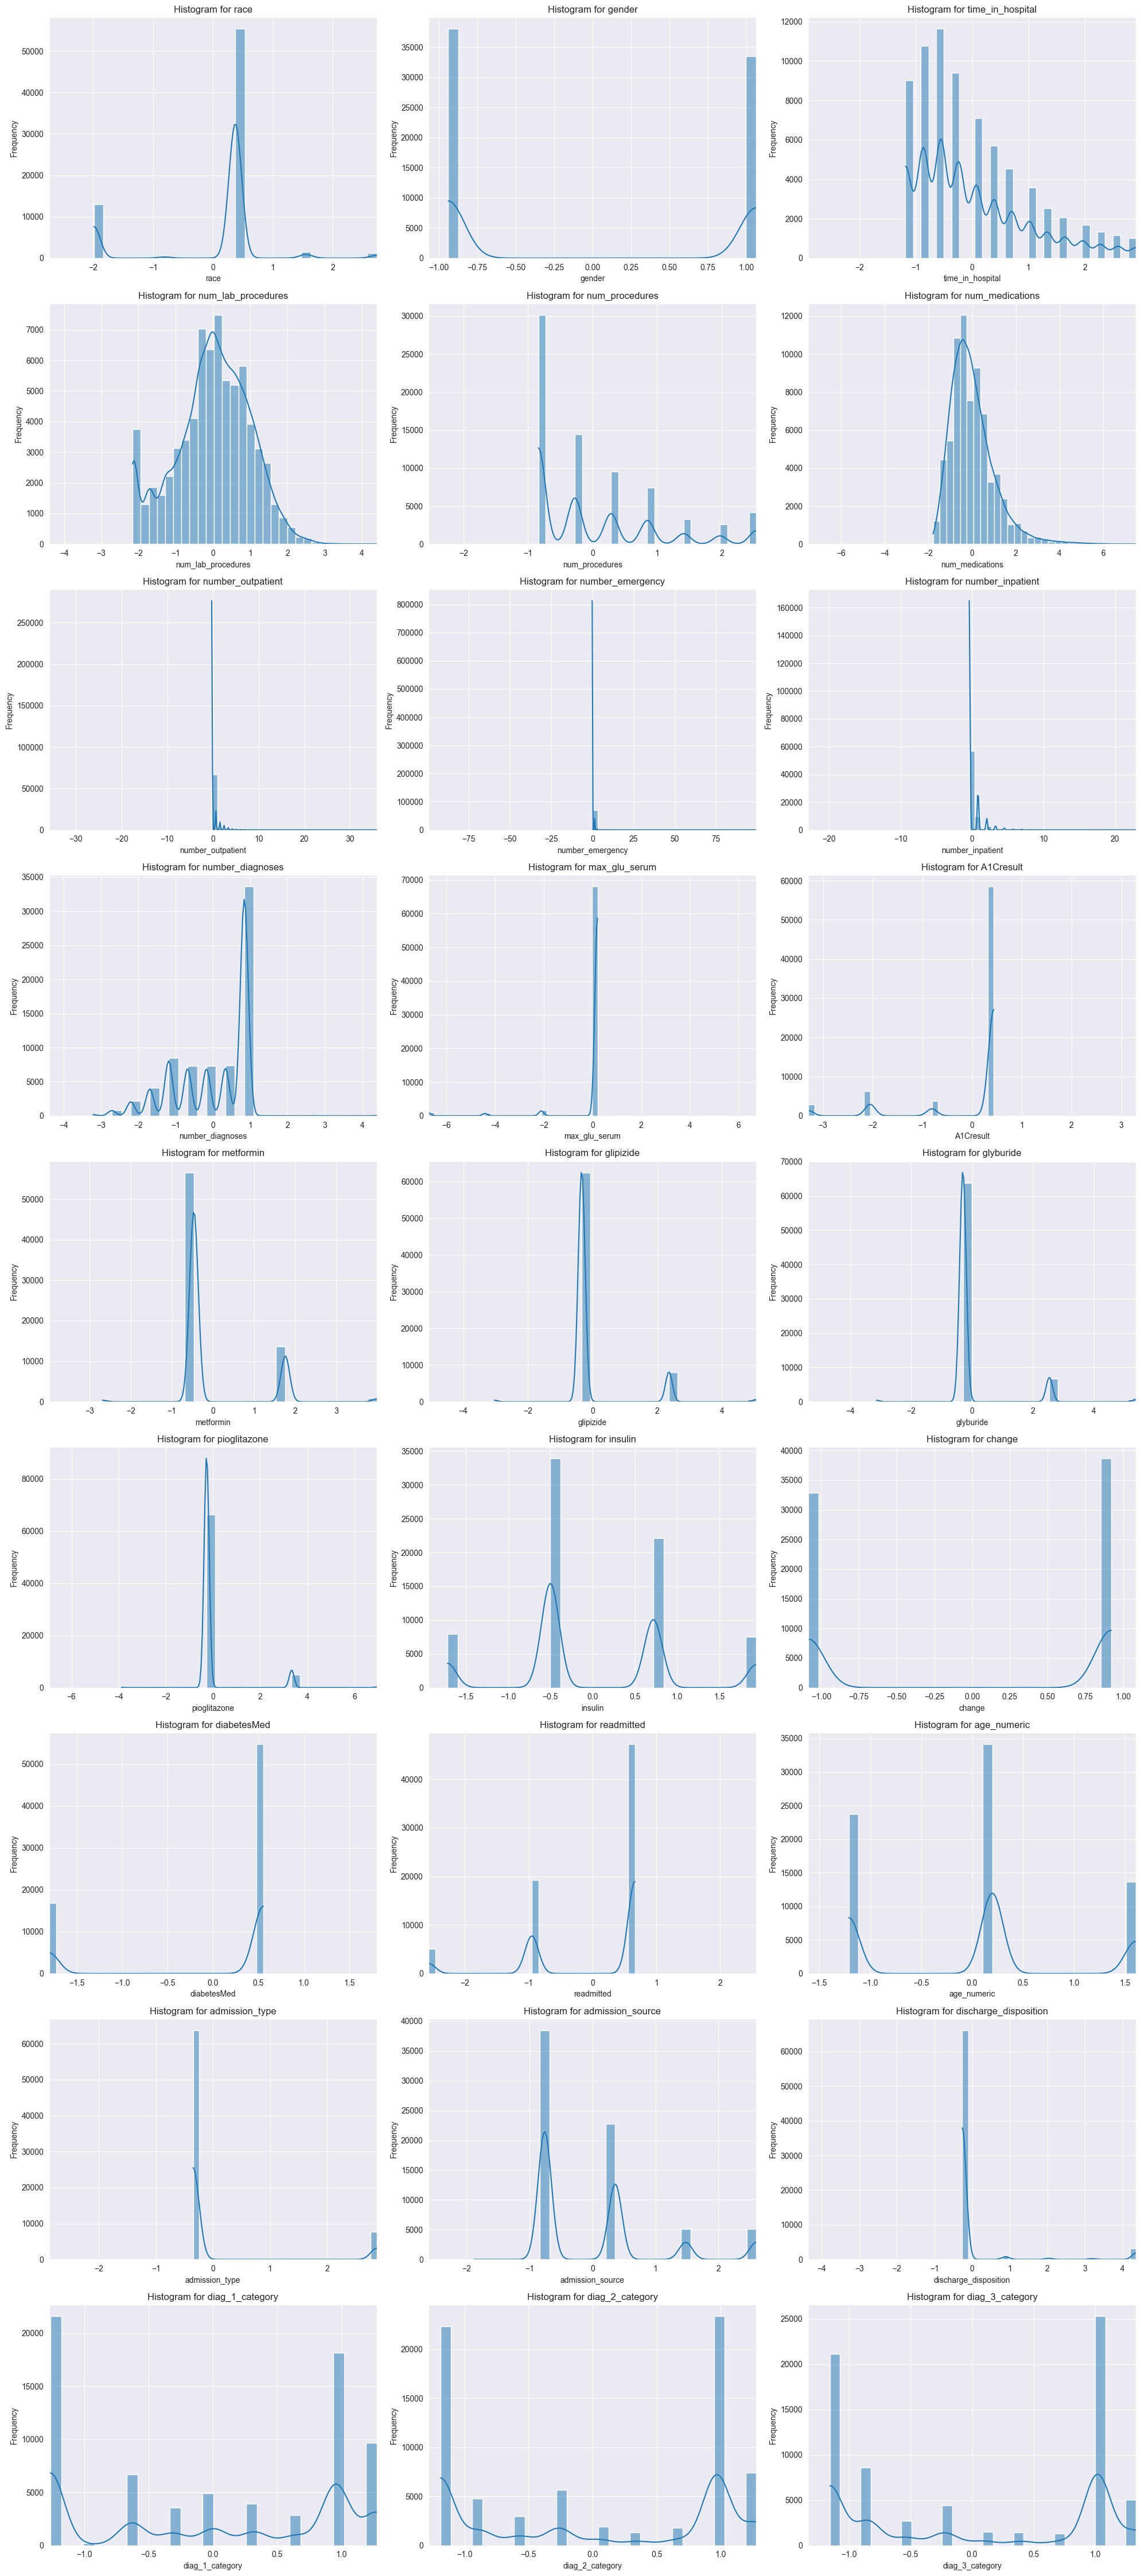

In [204]:
# Load datasets
diabetes_data = pd.read_csv('diabetes_preprocessed.csv')

# Function to plot histograms for each numerical feature in subplots
def plot_numerical_feature_distributions(df):
    num_columns = df.shape[1]
    num_rows = math.ceil(num_columns / 3)  # Number of rows needed to plot 3 plots per row
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(20, num_rows * 5))
    axes = axes.flatten()

    for i, column in enumerate(df.columns):
        # Determine the x-limits based on the maximum absolute value
        x_limit = max(abs(np.min(df[column])), abs(np.max(df[column])))
        sns.histplot(data=df, x=column, bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f'Histogram for {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlim(-x_limit, x_limit)  # Set x-limits dynamically
    
    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Call the function to plot all numerical features
plot_numerical_feature_distributions(diabetes_data)


## Task 2: Dimensionality Reduction

In [205]:
# Load the preprocessed data
diabetes_data = pd.read_csv('diabetes_preprocessed.csv')

# Store the original feature names
original_features = diabetes_data.columns.tolist()

# Apply PCA without specifying the number of components initially
pca = PCA()
principal_components = pca.fit_transform(diabetes_data)

# Create a DataFrame with the principal components
pca_columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]

# Display the explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(explained_variance, index=pca_columns, columns=['Explained Variance Ratio'])

print("Explained Variance Ratio for each Principal Component:")
print(explained_variance_df)

# Define the threshold for explained variance ratio
threshold = 0.07
print("\nThreshold of explained variance ratio for principal components:", threshold)

# Find the indices of components that have higher explained variance than the threshold
selected_indices = [i for i, variance in enumerate(explained_variance) if variance > threshold]

# Select the principal components that meet the threshold criterion
selected_principal_components = principal_components[:, selected_indices]

# Create a DataFrame with the selected principal components
selected_pca_columns = [f'PC{i+1}' for i in selected_indices]
selected_principal_df = pd.DataFrame(data=selected_principal_components, columns=selected_pca_columns)

# Display the explained variance ratio for the selected principal components
selected_explained_variance = explained_variance[selected_indices]
explained_variance_df = pd.DataFrame(selected_explained_variance, index=selected_pca_columns, columns=['Explained Variance Ratio'])

print("\nExplained Variance Ratio for Selected Principal Components:")
print(explained_variance_df)

# Retrieve the names of the original features contributing to each selected principal component
component_feature_contributions = pd.DataFrame(pca.components_, columns=original_features, index=pca_columns)
selected_feature_contributions = component_feature_contributions.loc[selected_pca_columns]

print("\nContributions of Original Features to Selected Principal Components:")
print(selected_feature_contributions)

# Save the selected principal components and their contributions to new CSV files
selected_principal_df.to_csv('diabetes_pca_selected.csv', index=False)
selected_feature_contributions.to_csv('selected_feature_contributions.csv')


Explained Variance Ratio for each Principal Component:
      Explained Variance Ratio
PC1                   0.091823
PC2                   0.072113
PC3                   0.070686
PC4                   0.060333
PC5                   0.049157
PC6                   0.044159
PC7                   0.041566
PC8                   0.040373
PC9                   0.039061
PC10                  0.038306
PC11                  0.036498
PC12                  0.035625
PC13                  0.034835
PC14                  0.032835
PC15                  0.032532
PC16                  0.032062
PC17                  0.029666
PC18                  0.029147
PC19                  0.027391
PC20                  0.025668
PC21                  0.024868
PC22                  0.023594
PC23                  0.021716
PC24                  0.018950
PC25                  0.017189
PC26                  0.015221
PC27                  0.014626

Threshold of explained variance ratio for principal components: 0.07

Explai

## Task 3: Unsupervised Learning

### K-Means

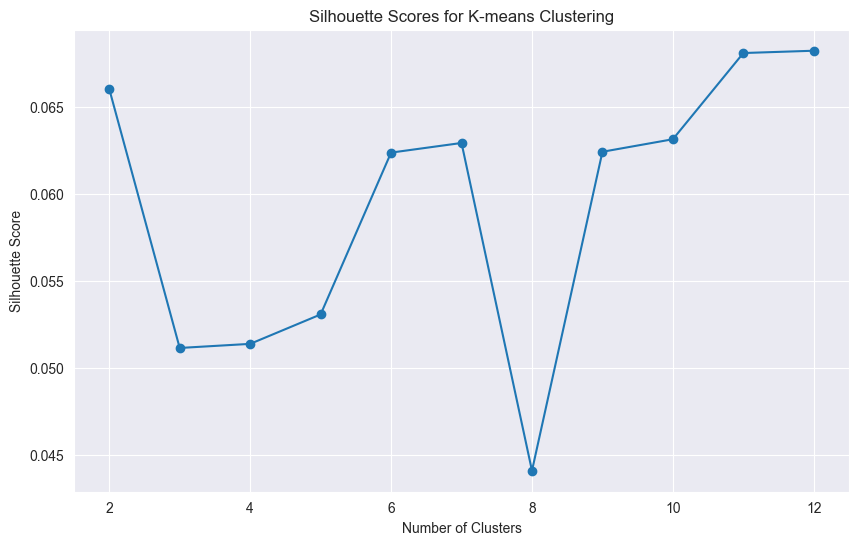

Optimal number of clusters for K-means: 12
with silhouette score: 0.0682


In [213]:
# Load the preprocessed data
diabetes_data = pd.read_csv('diabetes_preprocessed.csv')

# Determine the optimal number of clusters for K-means using the silhouette method
range_n_clusters = range(2, 13)
silhouette_scores_kmeans = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(diabetes_data)
    silhouette_avg = silhouette_score(diabetes_data, cluster_labels)
    silhouette_scores_kmeans.append(silhouette_avg)

# Plot silhouette scores for K-means
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores_kmeans, marker='o')
plt.title('Silhouette Scores for K-means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Find the optimal number of clusters
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores_kmeans)]
print(f'Optimal number of clusters for K-means: {optimal_n_clusters}')
print(f"with silhouette score: {np.max(silhouette_scores_kmeans):.4f}")

# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(diabetes_data)


### DBSCAN

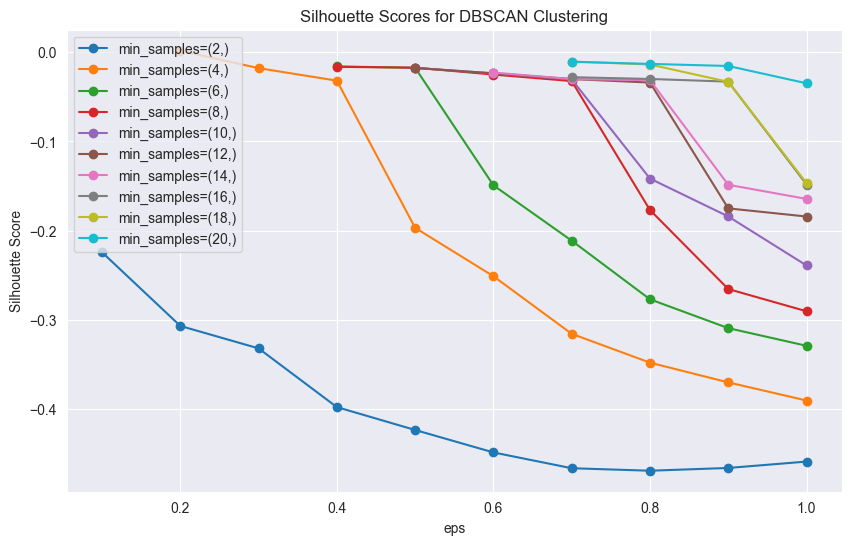

Optimal parameters for DBSCAN: min_samples=4, eps=0.2
with silhouette score: 0.00176


In [216]:
# Load the preprocessed data
diabetes_data = pd.read_csv('diabetes_preprocessed.csv')

# Determine the optimal parameters for DBSCAN using the silhouette method
min_samples_list = range(2, 21, 2)
eps_list = np.linspace(0.1, 1.0, 10)
best_silhouette_dbscan = -1
best_params_dbscan = {'min_samples': None, 'eps': None}

for min_samples in min_samples_list:
    for eps in eps_list:
        dbscan = DBSCAN(min_samples=min_samples, eps=eps)
        dbscan_labels = dbscan.fit_predict(diabetes_data)
        if len(set(dbscan_labels)) > 1:  # More than 1 cluster should be formed
            silhouette_avg = silhouette_score(diabetes_data, dbscan_labels)
            if silhouette_avg > best_silhouette_dbscan:
                best_silhouette_dbscan = silhouette_avg
                best_params_dbscan = {'min_samples': min_samples, 'eps': eps}

# Plot silhouette scores for DBSCAN
silhouette_scores_dbscan = []

for min_samples in min_samples_list:
    for eps in eps_list:
        dbscan = DBSCAN(min_samples=min_samples, eps=eps)
        dbscan_labels = dbscan.fit_predict(diabetes_data)
        if len(set(dbscan_labels)) > 1:
            silhouette_avg = silhouette_score(diabetes_data, dbscan_labels)
            silhouette_scores_dbscan.append((min_samples, eps, silhouette_avg))

# Convert to DataFrame for easy plotting
silhouette_scores_df = pd.DataFrame(silhouette_scores_dbscan, columns=['min_samples', 'eps', 'silhouette_score'])

# Plot the silhouette scores for DBSCAN
fig, ax = plt.subplots(figsize=(10, 6))
for key, grp in silhouette_scores_df.groupby(['min_samples']):
    ax.plot(grp['eps'], grp['silhouette_score'], label=f'min_samples={key}', marker='o')
ax.set_title('Silhouette Scores for DBSCAN Clustering')
ax.set_xlabel('eps')
ax.set_ylabel('Silhouette Score')
ax.legend()
plt.show()

# Perform DBSCAN clustering with the optimal parameters
optimal_min_samples = best_params_dbscan['min_samples']
optimal_eps = best_params_dbscan['eps']
print(f'Optimal parameters for DBSCAN: min_samples={optimal_min_samples}, eps={optimal_eps}')
print(f"with silhouette score: {best_silhouette_dbscan:.5f}")

dbscan = DBSCAN(min_samples=optimal_min_samples, eps=optimal_eps)
dbscan_labels = dbscan.fit_predict(diabetes_data)


### Results

In [217]:
# Create a DataFrame to store the results
result_df['kmean_label'] = kmeans_labels
result_df['dbscan_label'] = dbscan_labels

# Save the result to a CSV file
result_df.to_csv('clustering_results.csv', index=False)

### Visualization

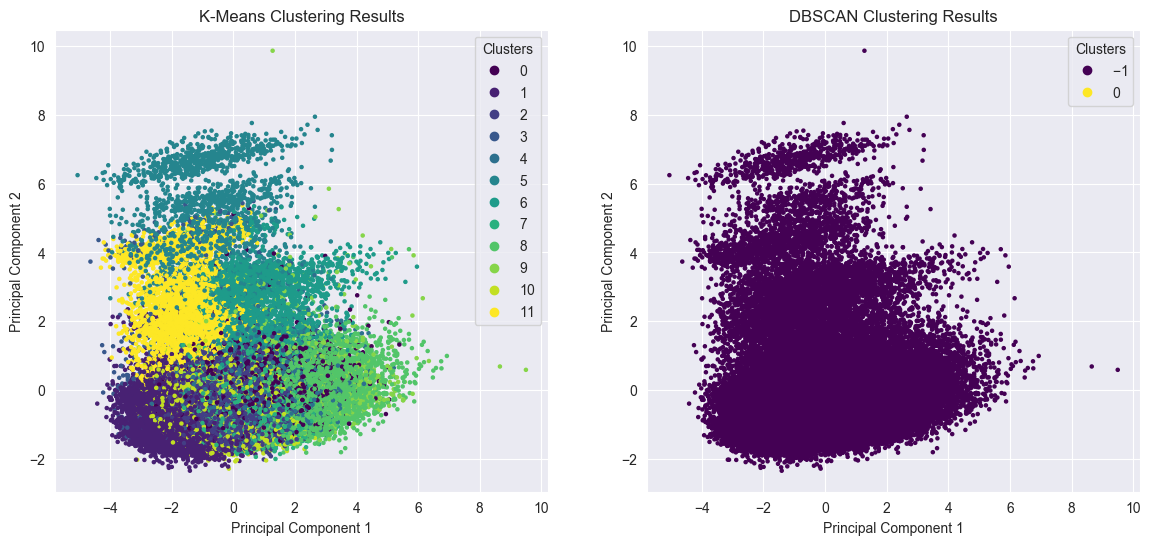

In [228]:
# Apply PCA to reduce the dataset to 2 components
pca = PCA(n_components=2)
principal_components_2d = pca.fit_transform(diabetes_data)

# Create a DataFrame with the 2 principal components
pca_df = pd.DataFrame(data=principal_components_2d, columns=['PC1', 'PC2'])

# Add the clustering labels to the DataFrame
pca_df['KMeans_Labels'] = kmeans_labels
pca_df['DBSCAN_Labels'] = dbscan_labels

# Plot the clustering results for K-Means
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
scatter_kmeans = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['KMeans_Labels'], cmap='viridis', s=5, marker='o')
plt.title('K-Means Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter_kmeans.legend_elements(), title="Clusters")

# Plot the clustering results for DBSCAN
plt.subplot(1, 2, 2)
scatter_dbscan = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['DBSCAN_Labels'], cmap='viridis', s=5, marker='o')
plt.title('DBSCAN Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter_dbscan.legend_elements(), title="Clusters")

plt.show()
